# Declaration of Originality

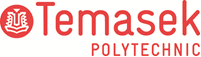

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Nathan James Abing
* Tutorial Group                : PC05
* Tutor						    : Kian Eng Ong
* Submission Date               : 11 February 2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [30]:
## Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

## Import Linear Regression model for model 1
from sklearn.linear_model import LinearRegression

## Import Random Forest Regressor for model 2
from sklearn.ensemble import RandomForestRegressor

## Import Gradient Boosting Regressor for model 3
from sklearn.ensemble import GradientBoostingRegressor

## Import Dummy Regressor for baseline model
from sklearn.dummy import DummyRegressor

# Import RandomizedSearchCV and TimeSeriesSplit for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


# 1. Business Understanding
Goal: Build a regression model to predict **Energy Production** output based on time and other generation factors (source, season, etc.)

Why it matters:
- Forecasting production helps planning like scheduling generation resources, anticipating peaks, and improving decision-making
- A simple input-driven model can support quick estimation for users (via a Streamlit web app).

Success criteria:
- Model must outperform a baseline (DummyRegressor).
- Lower MAE/RMSE and positive/stronger R^2 on a **time-based test set** are preferred.

# 2. Data Understanding
### Dataset overview:
- Target variable: **Production** numeric value.
- Key inputs include:
  - Time-related: Date, Start_Hour, Day_of_Year, Day_Name, Month_Name, Season
  - Context: Source (energy generation source)

### Initial observations:
- Because production is time-dependent, we will use a **time-based split** to avoid data leakage (training on future patterns).
- Some columns may be redundant (e.g., End_Hour = Start_Hour + 1), so feature selection/engineering is needed.

## 2.1 Load dataset

In [31]:
## Read *.csv file into pandas DataFrame
FILE_PATH = r"Energy Production Dataset.csv"  # <-- change if needed
df = pd.read_csv(FILE_PATH)
df

# Parse date and sort (important for time-based split)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Start_Hour"]).reset_index(drop=True)

# Helpful feature engineering
df["Is_Weekend"] = df["Day_Name"].isin(["Saturday", "Sunday"]).astype(int)

month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}
df["Month_Num"] = df["Month_Name"].map(month_map)

# Add "Year" column for feature engineering
df["Year"] = df["Date"].dt.year

# Cyclical encoding for Start_Hour (0–23)
df["Hour_sin"] = np.sin(2 * np.pi * df["Start_Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Start_Hour"] / 24)

# Cyclical encoding for Day_of_Year (1–365/366)
df["Doy_sin"] = np.sin(2 * np.pi * df["Day_of_Year"] / 365)
df["Doy_cos"] = np.cos(2 * np.pi * df["Day_of_Year"] / 365)


print(df.head())
print(df.info())

        Date  Start_Hour  End_Hour Source  Day_of_Year   Day_Name Month_Name  \
0 2020-01-01           0         1   Wind            1  Wednesday    January   
1 2020-01-01           1         2   Wind            1  Wednesday    January   
2 2020-01-01           2         3   Wind            1  Wednesday    January   
3 2020-01-01           3         4   Wind            1  Wednesday    January   
4 2020-01-01           4         5   Wind            1  Wednesday    January   

   Season  Production  Is_Weekend  Month_Num  Year  Hour_sin  Hour_cos  \
0  Winter        3542           0          1  2020  0.000000  1.000000   
1  Winter        2932           0          1  2020  0.258819  0.965926   
2  Winter        2725           0          1  2020  0.500000  0.866025   
3  Winter        2761           0          1  2020  0.707107  0.707107   
4  Winter        2708           0          1  2020  0.866025  0.500000   

    Doy_sin   Doy_cos  
0  0.017213  0.999852  
1  0.017213  0.999852  
2 

### Data loading & initial feature engineering:
- Converted `Date` to datetime and sorted by (`Date`, `Start_Hour`) to preserve chronological order for time-based modelling.
- Added `Year` to capture long-term trend differences across years.
- Added cyclical encodings:
  - `Hour_sin`, `Hour_cos` to represent the circular nature of hours (23 to 0).
  - `Doy_sin`, `Doy_cos` to represent annual seasonality smoothly (Dec to Jan).
### Rationale:
- Linear models benefit from continuous, meaningful representations (cyclical encoding avoids treating 23 and 0 as “far apart”).
- Tree/ensemble models can also benefit when periodic structure is made explicit.


## 2.2 Summary Statistics

In [32]:
## Understand the type of variable for each column
print("\nMissing values:\n", df.isna().sum())
print("\nTarget summary (Production):\n", df["Production"].describe())



Missing values:
 Date           0
Start_Hour     0
End_Hour       0
Source         0
Day_of_Year    0
Day_Name       0
Month_Name     0
Season         0
Production     0
Is_Weekend     0
Month_Num      0
Year           0
Hour_sin       0
Hour_cos       0
Doy_sin        0
Doy_cos        0
dtype: int64

Target summary (Production):
 count    51864.000000
mean      6215.069933
std       3978.364965
min         58.000000
25%       3111.000000
50%       5372.000000
75%       8501.000000
max      23446.000000
Name: Production, dtype: float64


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

### 2.3.1.1 Understanding distribution of target

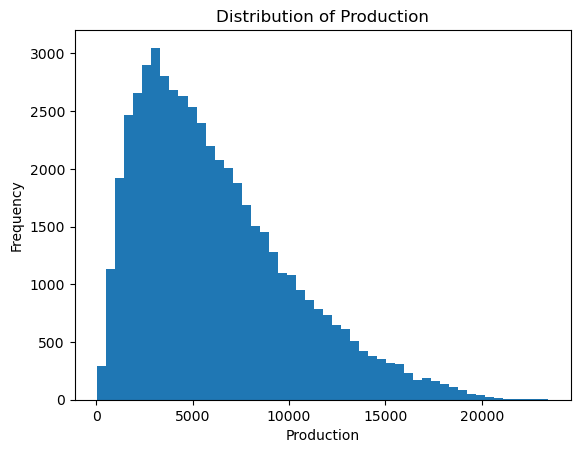

In [33]:
## Understanding distribution of target
# --- Target distribution: Production ---
plt.figure()
plt.hist(df["Production"], bins=50)
plt.title("Distribution of Production")
plt.xlabel("Production")
plt.ylabel("Frequency")
plt.show()


## EDA: Distribution of Production (Target Variable)

Observations:
- The distribution is **right-skewed**: most Production values cluster in the lower range, with a **long tail** extending to much higher values.
- There are likely **high-production outliers** (rare but very large values).

Implications for modelling:
- Because of the long tail, metrics behave differently:
  - **MAE** reflects typical error.
  - **RMSE** penalizes large errors more heavily, so a few high outliers can noticeably increase RMSE.
- This suggests that the model must handle both “normal production” periods and rare high-production periods.

Conclusion:
- I'll will evaluate using **both MAE and RMSE** to ensure the model performs well overall and does not fail badly on extreme cases.


### 2.3.1.2 Understanding distribution of features

<Figure size 640x480 with 0 Axes>

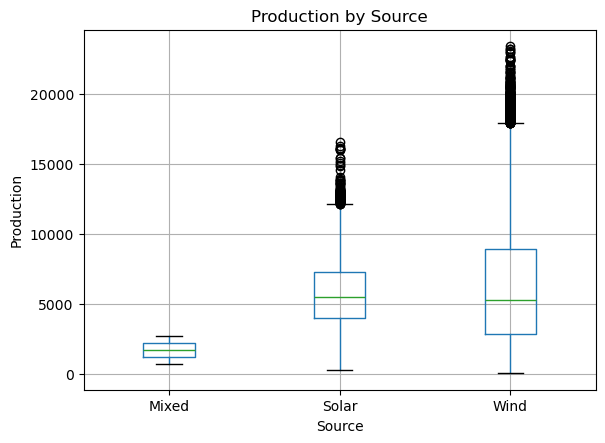

In [34]:
## Understanding distribution of features
# --- Production by Source (boxplot) ---
plt.figure()
df.boxplot(column="Production", by="Source")
plt.title("Production by Source")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Source")
plt.ylabel("Production")
plt.show()

### EDA: Production by Source

Observations:
- **Mixed** has the lowest median Production and the tightest spread (more consistent output).
- **Solar** has a higher median than Mixed and shows a wider spread, with several high outliers.
- **Wind** shows the **largest variability** and the highest extreme values (many high outliers), suggesting production can spike significantly depending on conditions.

Implications for modelling:
- `Source` is clearly a **strong predictor** because each category has noticeably different typical production levels and variability.
- The differences in spread also suggest the relationship is **not purely linear**, which motivates trying **tree-based/ensemble models** (e.g., Gradient Boosting).

Conclusion:
- `Source` should be kept as an input feature and encoded properly (OneHotEncoder) to allow the model to learn different behaviours for each generation type.


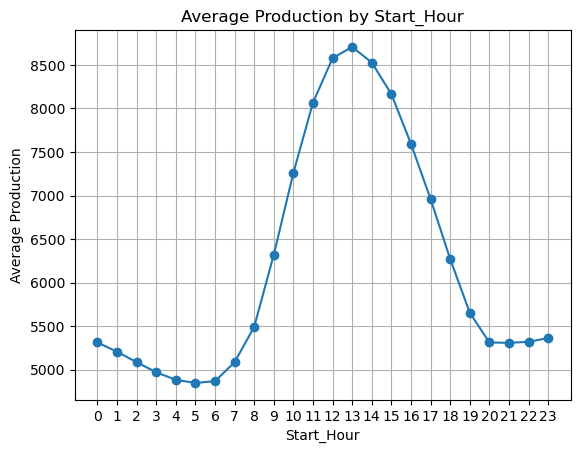

In [35]:
# --- Production by Start_Hour (average trend) ---
hourly_mean = df.groupby("Start_Hour")["Production"].mean()
plt.figure()
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.title("Average Production by Start_Hour")
plt.xlabel("Start_Hour")
plt.ylabel("Average Production")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

### EDA: Production by Start_Hour (Daily Pattern)

Observations:
- Production follows a strong **daily pattern**:
  - Lower production during early morning hours.
  - A clear rise through the morning.
  - A peak around **midday / early afternoon (approximately 12–14)**.
  - A gradual decline after the peak.

Implications for modelling:
- This confirms that time-of-day is a key driver of Production.
- Because time is **cyclical** (23 → 0), using raw hour values may mislead the model.
  - This supports feature engineering using **cyclical encoding (sin/cos)** for Start_Hour.

Conclusion:
- `Start_Hour` is retained and transformed using cyclical features (`Hour_sin`, `Hour_cos`) to better represent daily periodicity.


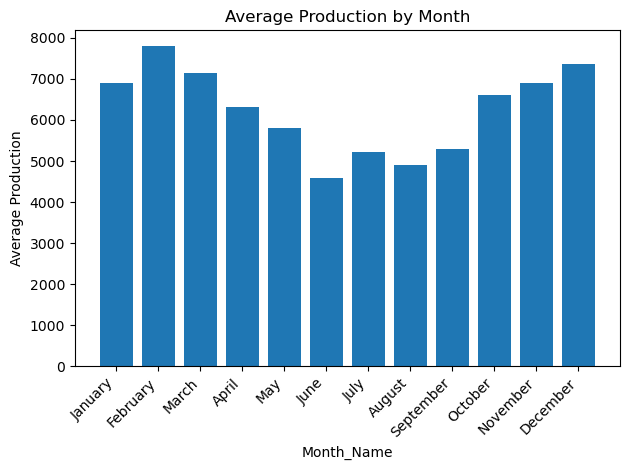

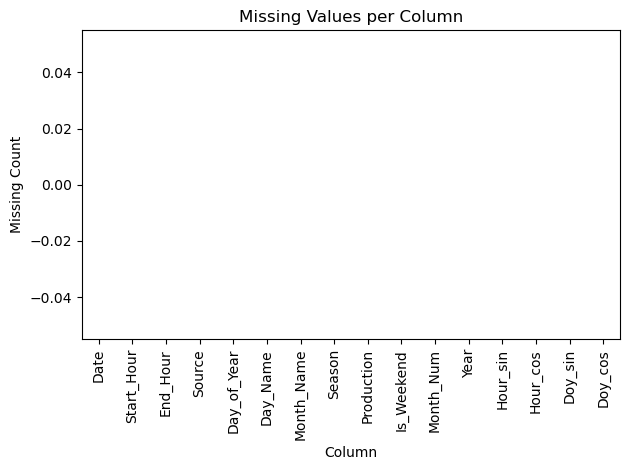

In [36]:
# --- Production by Month_Name (average) ---
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

monthly_mean = df.groupby("Month_Name")["Production"].mean().reindex(month_order)

plt.figure()
plt.bar(monthly_mean.index, monthly_mean.values)
plt.title("Average Production by Month")
plt.xlabel("Month_Name")
plt.ylabel("Average Production")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Check missing values visually ---
plt.figure()
(df.isna().sum().sort_values(ascending=False)).plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

### EDA: Production by Month (Seasonal Pattern)

Observations:
- Average Production varies noticeably by month, indicating a **seasonal effect**.
- Some months show consistently higher production compared to others, suggesting annual cycles.

Implications for modelling:
- Seasonal variation supports using time/season features such as:
  - `Month_Name` / `Season`
  - `Day_of_Year`
- Similar to hours, annual seasonality is also cyclical (end of year loops back to start of year).
  - This supports feature engineering using **cyclical encoding** for day-of-year (`Doy_sin`, `Doy_cos`).

Conclusion:
- We keep seasonality-related features and apply cyclic encoding to improve model generalization across the year.


### Data Quality: Missing Values

Observation:
- No missing values were found across the dataset columns.

Implications:
- No imputation or row removal is required.
- This reduces preprocessing complexity and avoids introducing imputation bias.

Conclusion:
- The dataset can be used directly after feature engineering and encoding.


## EDA Summary and Decisions

Key insights from EDA:
- The target (`Production`) is **right-skewed** with high outliers, so we evaluate using both MAE and RMSE.
- `Source` strongly affects Production, so it must be included and encoded properly.
- Production has clear **daily** and **seasonal** patterns (Start_Hour and Month/Day-of-Year effects).

Actions taken based on EDA:
1) **Feature Engineering**
   - Added `Year` to capture long-term differences across years (trend/drift).
   - Applied **cyclical encoding** to represent periodic time behaviour:
     - `Hour_sin`, `Hour_cos`
     - `Doy_sin`, `Doy_cos`
2) **Evaluation Plan**
   - Use **MAE** for typical error.
   - Use **RMSE** to penalize large mistakes (important due to outliers).
   - Track **R²** to assess explained variance and verify improvement beyond baseline.
3) **Validation Strategy**
   - Use a **time-based split** to simulate real forecasting (train on earlier data, test on later data).


## 2.3.2 Understanding relationship between variables


### Relationships between variables:
- For numeric features, correlation checks help identify whether any time-derived signals (e.g., Year, cyclic components) relate to Production.
- For categorical features like Source, comparing group distributions (boxplots) reveals whether categories carry predictive signal.

### Implications:
- If time-derived features show consistent relationship with production, they should remain in the feature set.
- If a feature shows weak/unstable relationship, it may be removed during feature selection to simplify the model.

# 3. Data Preparation

## 3.1 Data Cleaning

In [37]:
target_col = "Production"

feature_cols = [
    "Hour_sin", "Hour_cos",
    "Doy_sin", "Doy_cos",
    "Year",       
    "Source",
    "Day_Name",
    "Month_Name",
    "Season"
]

# Time-based split
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].copy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (41491, 9) Test size: (10373, 9)


## Feature selection & preparation:
### Chosen features:
- Numeric engineered: Hour_sin, Hour_cos, Doy_sin, Doy_cos, Year
- Categorical: Source, Day_Name, Month_Name, Season

### Why these features:
- Cyclical features represent repeating patterns more naturally than raw hour/day-of-year.
- Year captures long-term shifts across years.
- Source/season/month/day capture contextual differences in generation.

### Note on redundancy:
- Columns like End_Hour were excluded because it is derived from Start_Hour (adds little new information).


## 3.2 Train-Test Split

In [38]:
# Time-based Train-Test Split (first 80% train, last 20% test)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

print("Train size:", train_df.shape, "Test size:", test_df.shape)

Train size: (41491, 16) Test size: (10373, 16)


# 4. Modelling

### 4.2 Train Model

In [39]:
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]   # keep for later evaluation
y_test = test_df[target_col]     # keep for later evaluation

numeric_features = ["Hour_sin", "Hour_cos", "Doy_sin", "Doy_cos", "Year"]
categorical_features = ["Source", "Month_Name", "Season", "Day_Name"]

# Preprocessing: Linear needs scaling; Tree doesn't
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# Define pipelines for both models
pipe_linr = Pipeline(steps=[
    ("preprocess", preprocess_linear),
    ("model", LinearRegression())
])

pipe_gb = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", GradientBoostingRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    ))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

pipe_dummy = Pipeline(steps=[
    ("preprocess", preprocess_tree),   # one-hot encodes categories
    ("model", DummyRegressor(strategy="mean"))
])


In [40]:
# Train models

pipe_linr.fit(X_train, y_train)
pipe_gb.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_dummy.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model setup (pipelines & preprocessing):
- Used `ColumnTransformer` + `Pipeline` so preprocessing is applied consistently and safely.
- Numeric scaling is used for Linear Regression (helps optimization and comparability).
- Tree-based models do not require scaling, so numeric values are passed through.
- Categorical features are one-hot encoded to convert categories into model-readable format.

### Models trained:
- DummyRegressor (mean baseline): establishes a minimum benchmark.
- LinearRegression: simple interpretable baseline.
- RandomForestRegressor: ensemble method for non-linear patterns.
- GradientBoostingRegressor: boosting method that often performs well on structured/tabular data.


# 5. Model Evaluation

In [41]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# ---- Predict ----
pred_linr = pipe_linr.predict(X_test)
pred_gb = pipe_gb.predict(X_test)
pred_rf = pipe_rf.predict(X_test)
pred_dummy = pipe_dummy.predict(X_test)

# ---- Metrics ----
results = []
m1 = regression_metrics(y_test, pred_linr)
m1["Model"] = "LinearRegression (Baseline)"
results.append(m1) 

m2 = regression_metrics(y_test, pred_rf)
m2["Model"] = "RandomForestRegressor"
results.append(m2)

m3 = regression_metrics(y_test, pred_gb)
m3["Model"] = "GradientBoostingRegressor"
results.append(m3)

m0 = regression_metrics(y_test, pred_dummy)
m0["Model"] = "DummyRegressor (Mean Baseline)"
results.append(m0)

results_df = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
results_df

,MAE,MSE,RMSE,R2
Model,,,,
LinearRegression (Baseline),3368.403697,1.717562e+07,4144.348467,0.109354
GradientBoostingRegressor,3207.226112,1.742589e+07,4174.432898,0.096376
RandomForestRegressor,3412.049921,2.045485e+07,4522.704133,-0.060692
DummyRegressor (Mean Baseline),3496.065172,2.055024e+07,4533.237634,-0.065638


### Main evaluation metric: **Mean Absolute Error, MAE**
Average absolute error, chosen as main metric as it is in the same unit as production, and thus the easiest to explain, especially for business users
### Other chosen evaluation metrics:
- **RMSE**: Penalizes large errors more heavily, important if large under/over-estimates become costly for business planning
- **R^2**: Indicates how much variance in production is explained by the model, good to know for business users where higher means better

### Initial model evaluation results:
- Looking at the results, Linear Regression achieved the best overall performance with the lowest RMSE value, and the highest R^2 value, while Gradient Boosting had slightly better MAE. Since large prediction errors are more harmful in energy forecasting, we prioritize RMSE. However, due to the closeness in values between Linear Regression and the Gradient Boosting model, I feel with RandomizedSearchCV tuning, the latter could surpass the former.

## 6. Hyperparameter tuning
### Hyperparameter tuning approach:
- After comparing multiple models, GradientBoostingRegressor was selected for tuning.
- RandomizedSearchCV is used (required), with limited values per hyperparameter as per project specs.
- Vary multiple hyperparameters and compare tuned vs untuned performance to ensure tuning produces measurable improvement.

### Reproducibility:
- Random seeds are fixed (random_state=42).
- We use cross-validation during tuning to reduce the chance of overfitting to a single split.


In [42]:
# Hyperparameter tuning for GradientBoostingRegressor

pipe_gb_base = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", GradientBoostingRegressor(random_state=42))
])

# IMPORTANT: No more than 3 values per hyperparameter.
# We'll tune 3 hyperparameters with exactly 3 values each.
param_dist_gb = {
    "model__n_estimators": [150, 300, 500],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4]
}

# Time-series friendly cross validation
tscv = TimeSeriesSplit(n_splits=5)

rs_gb = RandomizedSearchCV(
    estimator=pipe_gb_base,
    param_distributions=param_dist_gb,
    cv=tscv,  # 5 folds, time-aware
    scoring="neg_mean_squared_error",
    n_iter=10, 
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_gb.fit(X_train, y_train)

print("Best parameters:", rs_gb.best_params_)
best_cv_rmse = np.sqrt(-rs_gb.best_score_)
print("Best CV RMSE:", best_cv_rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__n_estimators': 150, 'model__max_depth': 3, 'model__learning_rate': 0.05}
Best CV RMSE: 3407.761355225885


### Tuned hyperparameters:
- n_estimators: controls number of boosting stages (more can reduce bias but may overfit).
- learning_rate: controls contribution of each stage (smaller can generalize better, needs more estimators).
- max_depth: controls complexity of each base learner (higher captures non-linear patterns but may overfit).


## 7. Model evaluation after RandomizedSearch

In [43]:
# Extract the tuned best pipeline
best_gb_pipe = rs_gb.best_estimator_

# Predict on test set
pred_gb_tuned = best_gb_pipe.predict(X_test)

# Evaluate using your existing metric function
m_gb_tuned = regression_metrics(y_test, pred_gb_tuned)
m_gb_tuned["Model"] = "GradientBoostingRegressor (Tuned)"
results.append(m_gb_tuned)

# Compare again
results_df = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
results_df


,MAE,MSE,RMSE,R2
Model,,,,
GradientBoostingRegressor (Tuned),3168.346070,1.663490e+07,4078.589928,0.137393
LinearRegression (Baseline),3368.403697,1.717562e+07,4144.348467,0.109354
GradientBoostingRegressor,3207.226112,1.742589e+07,4174.432898,0.096376
RandomForestRegressor,3412.049921,2.045485e+07,4522.704133,-0.060692
DummyRegressor (Mean Baseline),3496.065172,2.055024e+07,4533.237634,-0.065638


### Tuned model results & selection:
- The tuned GradientBoostingRegressor achieved the best overall balance:
  - Lowest MAE and RMSE, with values of 3168.3 and 4078.6 respectively (better accuracy and fewer large errors)
  - Highest R^2 value, 0.137393 (explains around 13.7% of variance in Production)

### Final selection (based on evidence):
- Selected **GradientBoostingRegressor (Tuned)** as the final model because it outperformed the baselines on the time-based test set.
- This aligns with the goal of predicting future production from historical patterns and contextual inputs.


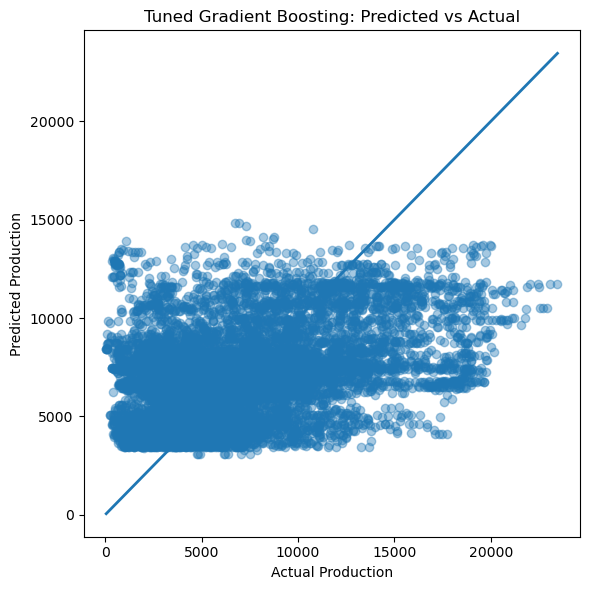

In [44]:
# Convert y_test to a NumPy array (safe for plotting)
y_true = np.array(y_test)
y_pred = np.array(pred_gb_tuned)


# 1) Predicted vs Actual

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.title("Tuned Gradient Boosting: Predicted vs Actual")
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linewidth=2)

plt.tight_layout()
plt.show()

### Tuned Gradient Boosting: Predicted vs Actual (Test Set)

What we observe:
- The points show a **positive trend** (as actual production increases, predicted production generally increases), which confirms the model is learning meaningful signal.
- However, the predictions are **compressed into a narrower band** compared to the full range of actual values.
  - Many predictions cluster roughly in the mid-range (around ~4k to ~13k), even when actual values extend beyond that.
- At the **high end of actual production**, the model often predicts lower than the actual values (points appear below the diagonal reference line).
  - This suggests the model tends to **underestimate extreme high production periods**.

Interpretation:
- The model performs best for “typical” production levels but struggles to perfectly match rare extreme peaks.
- This behaviour is consistent with the earlier EDA showing a **right-skewed target distribution** (high values are rarer), meaning the model sees fewer examples of very high production during training.

Conclusion:
- The tuned model is suitable for general estimation and trend prediction, but its accuracy decreases for extreme high-production cases.


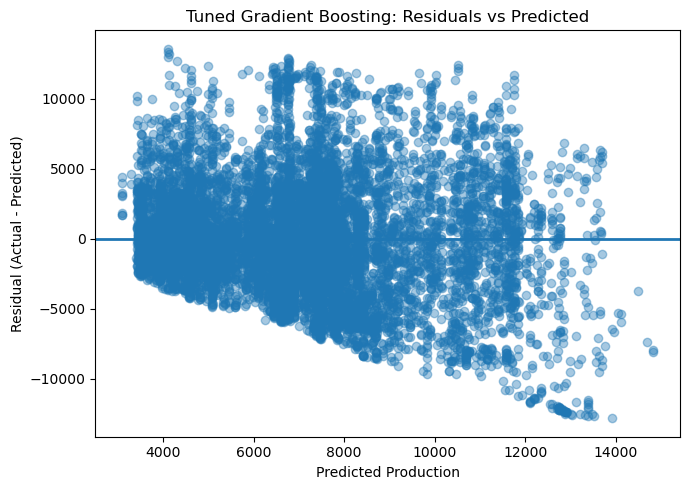

In [45]:
# 2) Residual Plot (Residuals vs Predicted)

residuals = y_true - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.title("Tuned Gradient Boosting: Residuals vs Predicted")
plt.xlabel("Predicted Production")
plt.ylabel("Residual (Actual - Predicted)")

# Zero line
plt.axhline(0, linewidth=2)

plt.tight_layout()
plt.show()

### Tuned Gradient Boosting: Residuals vs Predicted (Test Set)

What we observe:
- Residuals are not perfectly random: there is a noticeable **pattern / slope** where residuals trend more negative as predicted production increases.
- For larger predicted values, many residuals are **strongly negative**, meaning:
  - **Actual - Predicted < 0** → the model is often **overpredicting** in that region.
- There is also a **wide spread** of residuals (large positive and negative values), indicating prediction error varies substantially across different production levels.
- The spread appears larger at higher prediction values (a mild “fan-out”), suggesting **heteroscedasticity** (error variance changes with the level of production).

Interpretation:
- The model has some bias depending on the production range:
  - In certain regions it tends to systematically overpredict or underpredict rather than making purely random errors.
- This is expected for a dataset where key drivers of production (e.g., weather conditions for wind/solar) are not included, so the model can only estimate based on time/context patterns.

Conclusion:
- The residual plot indicates the model is not perfect and still has structured error, but it remains useful because it improves over baseline and captures overall trends.
- Future improvements would likely require additional explanatory variables (e.g., weather, capacity, operational constraints), which are outside the current dataset scope.
- Because extreme values exist and residual variance is not constant, we report both MAE (typical error) and RMSE (penalizes large errors) to provide a more complete evaluation.

## 8. Save model (For Streamlit)


In [46]:
# Save the best model to disk

joblib.dump(best_gb_pipe, "best_energy_model.pkl")
print("Saved tuned model -> best_energy_model.pkl")

Saved tuned model -> best_energy_model.pkl


## Saving model for deployment:
- The saved object is a full pipeline (preprocessing + model), so Streamlit can directly load it and call `.predict()`.
- Important: The Streamlit app must recreate the same feature columns used during training (Hour_sin/cos, Doy_sin/cos, Year, and categorical inputs).


## Development / iteration log (evidence of refinement):
1) Baseline models trained (Dummy, Linear, RF, GB) using time-based split.
2) Feature engineering introduced:
   - Added Year to capture long-term changes
   - Added cyclical features for Start_Hour and Day_of_Year
3) Model comparison performed on test set (results table shown above).
4) Hyperparameter tuning applied to the best candidate (GB) using RandomizedSearchCV.
5) Tuned model evaluated and selected based on improved MAE/RMSE/R^2.

(Version control evidence: GitHub commit history screenshots included in the submission Word document.)
